In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import asarray
from PIL import Image, ImageEnhance
from scipy import ndimage
from scipy.ndimage import rotate
from skimage.measure import block_reduce
from skimage.segmentation import clear_border
from skimage import data, filters, measure, morphology
import math
import pandas as pd
import imutils
import csv
import os
import tifffile

In [3]:
pixels_to_um=35/96   #confirm
unit_hight=161        #the height of each nanowell unit (in pix)
unit_width=161      #the width of each nanowell unit (in pix)
angle=1           #rotating the point (3, 4) around an origin of (2, 2) clockwise by an angle of xxx degrees
M=40                 #how many units in each row
N=40              #how many units in each column
thick=20           #litle bit larger: some cells touching nanowells

#a peek at the result
def plt_fun(arr, title, size=(10,10)):
    plt.figure(figsize=size)
    plt.imshow(arr)
    plt.title(title)
    #plt.colorbar()
    plt.show()

#plot the 2D grid overlapped with edges of each nanowell unit
def nano_mask(start_x, start_y, Unit_hight, Unit_width, m, n): 
    ver_lines=[]
    hor_lines=[]
    mask_lines=[]
    for i in range (m+1):
        ver_lines.append(start_x+i*Unit_width)

    for i in range (n+1):
        hor_lines.append(start_y+i*Unit_hight)

    right_bottom_x=start_x+m*Unit_width
    right_bottom_y=start_y+n*Unit_hight

    for i in range (m+1):
        mask_lines.append([ver_lines[i], start_y, ver_lines[i], right_bottom_y])   
        
    for i in range (n+1):
        mask_lines.append([start_x, hor_lines[i], right_bottom_x, hor_lines[i]])   
    return mask_lines


#----------------------------------
#build a lookup table for unit address. Unit No.0 is top left one. 
table=[] # a list
count=0
for i in range(N*N):
    table.append([(i%M)*unit_width, (i//M)*unit_hight])

#draw a square for wanted units. Need to use the looup table
def draw_unit(img, cell_list):
    fig = plt.figure(figsize=(17, 17))
    fig.add_subplot(1, 1, 1)
    for i in range(len(cell_list)):
        x=int(table[cell_list[i]][0])
        y=int(table[cell_list[i]][1])
        cv2.rectangle(img, pt1=(x,y), pt2=(x+unit_width,y+unit_hight), color=(255,0,0), thickness=10)
    plt.imshow(img, vmin=0, vmax=100)

    ###fig.add_subplot(2, 1, 2)
    #whiteblankimage = 255 * np.ones(shape=(img.shape[0],img.shape[1], 3), dtype=np.uint8)
    #for i in range(len(cell_list)):
    #    x=int(table[cell_list[i]][0])
    #    y=int(table[cell_list[i]][1])
    #    cv2.rectangle(whiteblankimage, pt1=(x,y), pt2=(x+unit_width,y+unit_hight), color=(0,0,0), thickness=20)
    #    cv2.putText(whiteblankimage, text=str(cell_list[i]), org=(x-50,y+120),fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=3, color=(255,0,0),thickness=10, lineType=cv2.LINE_AA)
    #plt.imshow(whiteblankimage)
    #plt.show()### 

In [4]:
#load images: Brightfield(BF), Fluorescent image (FF)

OME_directory = r'G:\mju cloud\OneDrive - UBC\Data\2023\week5\raw_20230131 GSIS'
OME_base_name = 'WellB21_ChannelBF_20XELWD,DAPI_20XELWD,EGFP_20XELWD,CY5_20XELWD,CY3_20XELWD_Seq0000_Jayden.tif'

filename_OME= os.path.join(OME_directory, OME_base_name)
print("File path:", filename_OME)
img1_BF = tifffile.imread(filename_OME, key=0)
#img1_BF = cv2.cvtColor(img1_BF,cv2.COLOR_BGR2GRAY)
img1_DAPI = tifffile.imread(filename_OME, key=1)
img1_DAPI = cv2.normalize(img1_DAPI, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img1_EGFP = tifffile.imread(filename_OME, key=2)
img1_EGFP = cv2.normalize(img1_EGFP, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img1_CY5 = tifffile.imread(filename_OME, key=3)
img1_CY5 = cv2.normalize(img1_CY5, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#img1_DAPI = cv2.cvtColor(img1_DAPI,cv2.COLOR_BGR2GRAY)



File path: G:\mju cloud\OneDrive - UBC\Data\2023\week5\raw_20230131 GSIS\WellB21_ChannelBF_20XELWD,DAPI_20XELWD,EGFP_20XELWD,CY5_20XELWD,CY3_20XELWD_Seq0000_Jayden.tif


<class 'numpy.ndarray'>


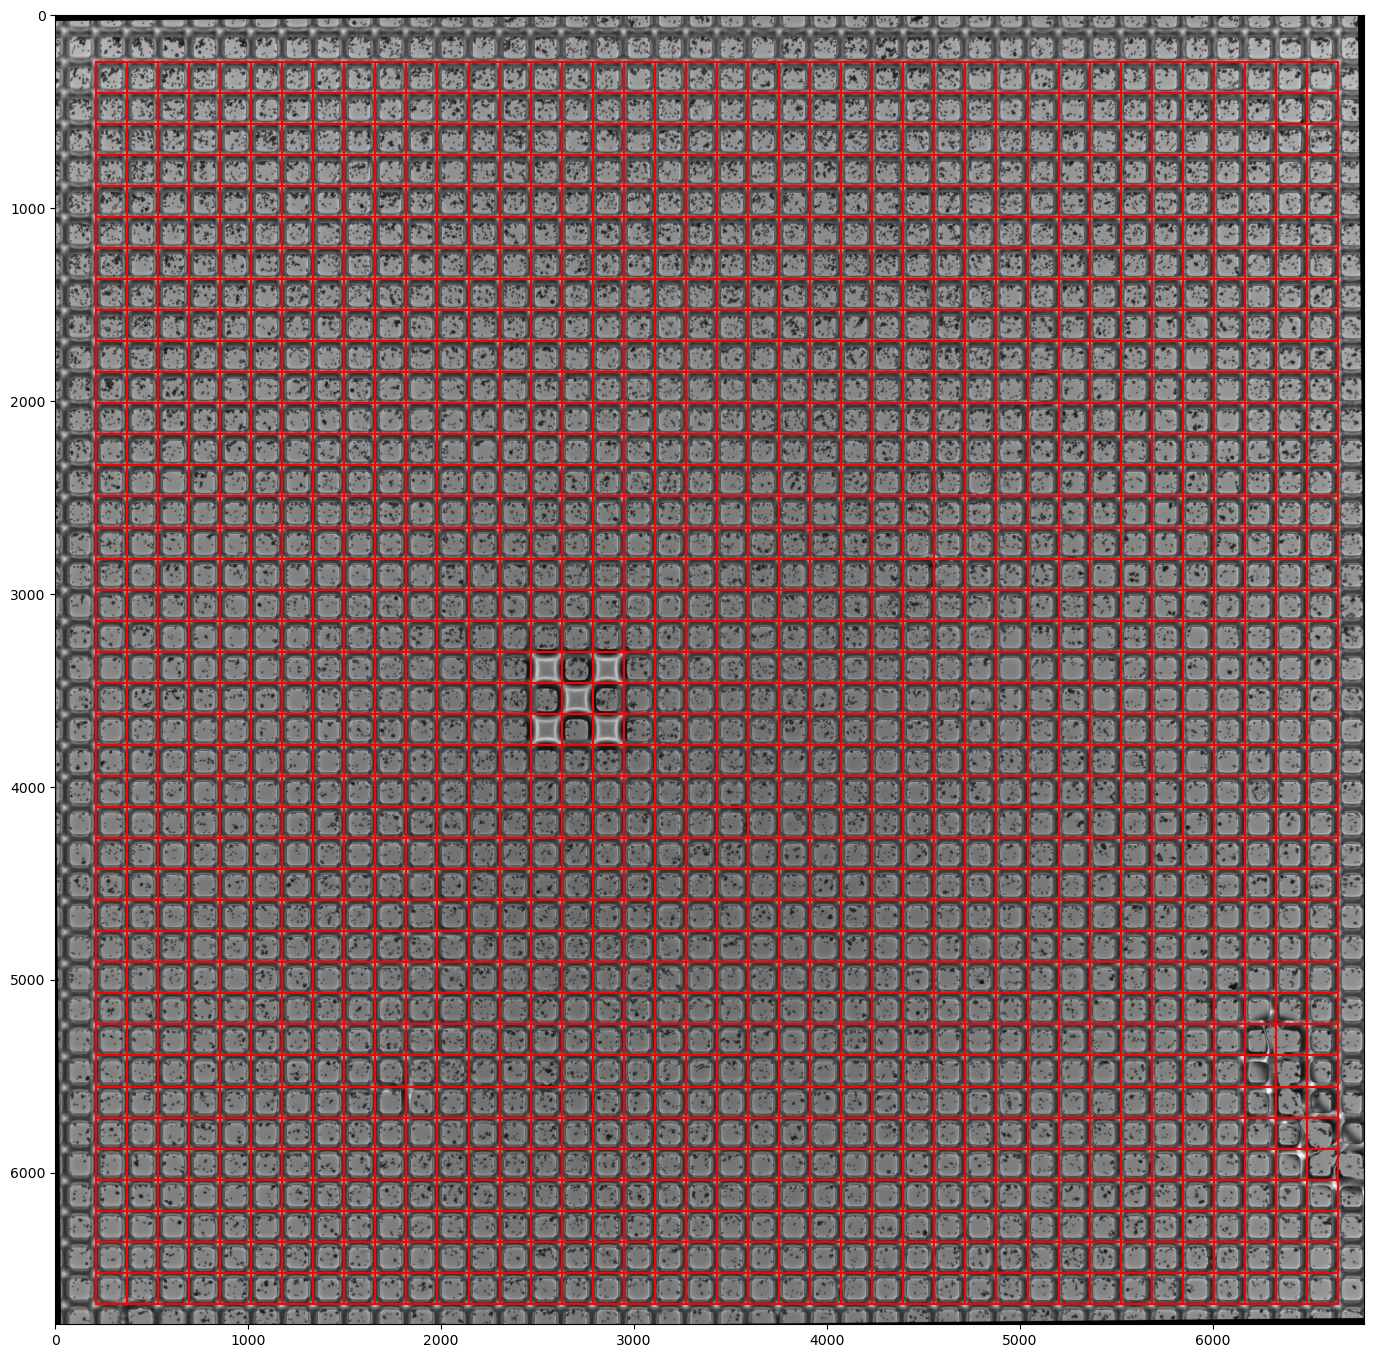

In [8]:
#find the start point and rotate angle (a 2D grid patterns from the top left point (start point))
start1_x=210 #250 #200 #148 #255 #200 #145 #95 #200 #145
start1_y=240 #282 #279 #270 #260 #245 #240 #225 #215 #210
angle=0.53
#BF img: rotate
print(type(img1_BF))
img1_BF_rotate=imutils.rotate(img1_BF, angle)
mask1_lines= nano_mask(start1_x, start1_y, unit_hight, unit_width, M, N)

plt.figure(figsize=(17,17))
plt.imshow(img1_BF_rotate, cmap="gray")
for x1, y1, x2, y2 in mask1_lines:
    plt.plot([x1, x2], [y1, y2], "r")
plt.show()


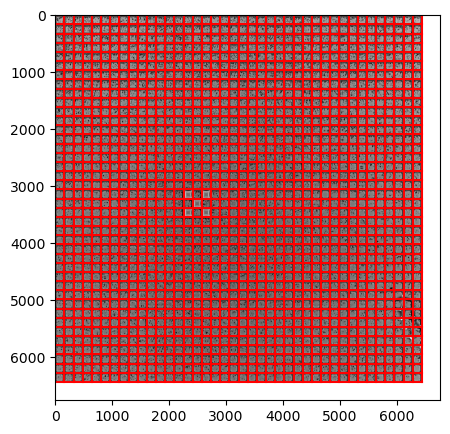

In [9]:
#BF img:crop
rotate_angle=angle
img1_cropBF=img1_BF_rotate[int(mask1_lines[M+1][3]): int(mask1_lines[M+N+1][3]), int(mask1_lines[0][0]):int(mask1_lines[M][0])]
mask2_lines= nano_mask(0, 0, unit_hight, unit_width, M, N)
#DAPI img: rotate, crop
img1_DAPI_rotate=imutils.rotate(img1_DAPI, angle=rotate_angle)
img1_DAPI_crop=img1_DAPI_rotate[int(mask1_lines[M+1][3]): int(mask1_lines[M+N+1][3]), int(mask1_lines[0][0]):int(mask1_lines[M][0])]
#EGFP img: rotate, crop
img1_EGFP_rotate=imutils.rotate(img1_EGFP, angle=rotate_angle)
img1_EGFP_crop=img1_EGFP_rotate[int(mask1_lines[M+1][3]): int(mask1_lines[M+N+1][3]), int(mask1_lines[0][0]):int(mask1_lines[M][0])]
#CY5 img: rotate, crop
img1_CY5_rotate=imutils.rotate(img1_CY5, angle=rotate_angle)
img1_CY5_crop=img1_CY5_rotate[int(mask1_lines[M+1][3]): int(mask1_lines[M+N+1][3]), int(mask1_lines[0][0]):int(mask1_lines[M][0])]

#check cropped image 
plt.figure(figsize=(5,5))
plt.imshow(img1_cropBF, cmap="gray")
for x1, y1, x2, y2 in mask2_lines:
    plt.plot([x1, x2], [y1, y2], "r")
plt.show()


<Figure size 500x500 with 0 Axes>

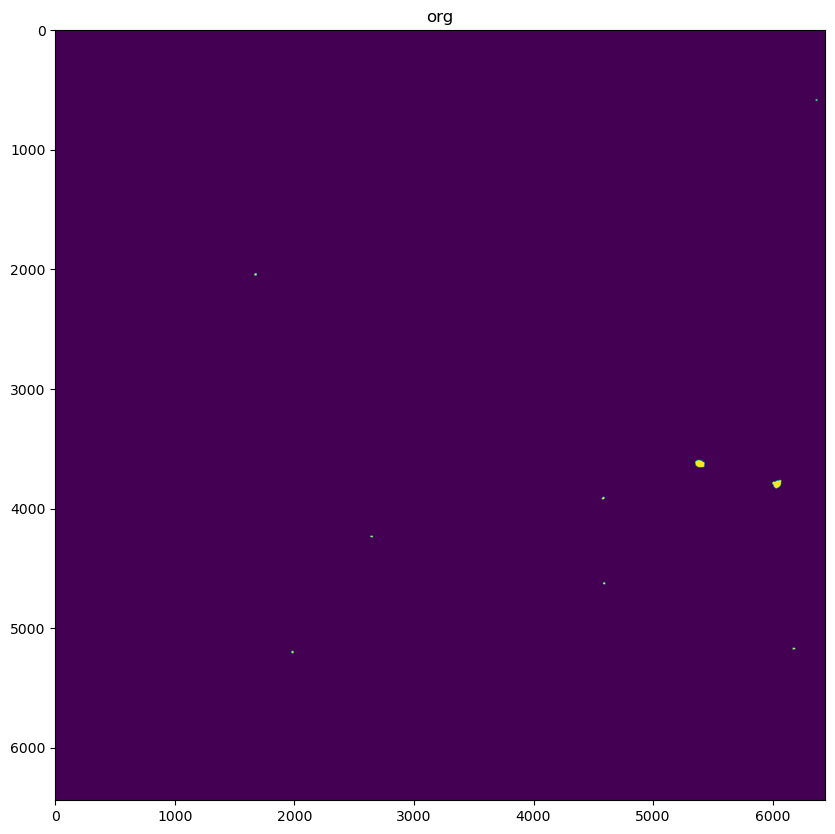

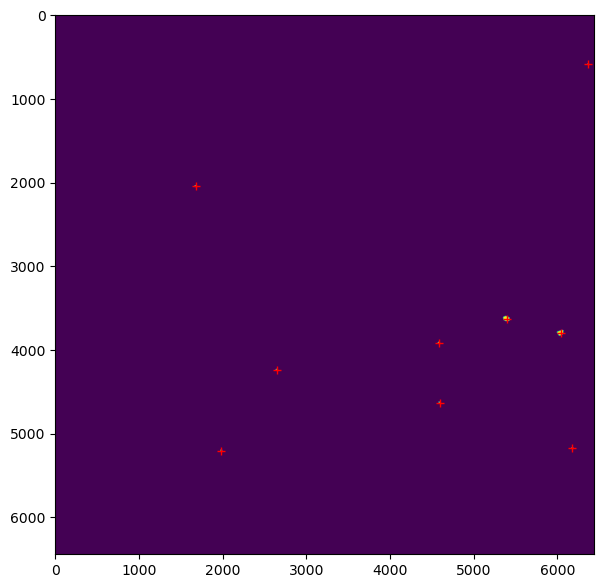

7
Done


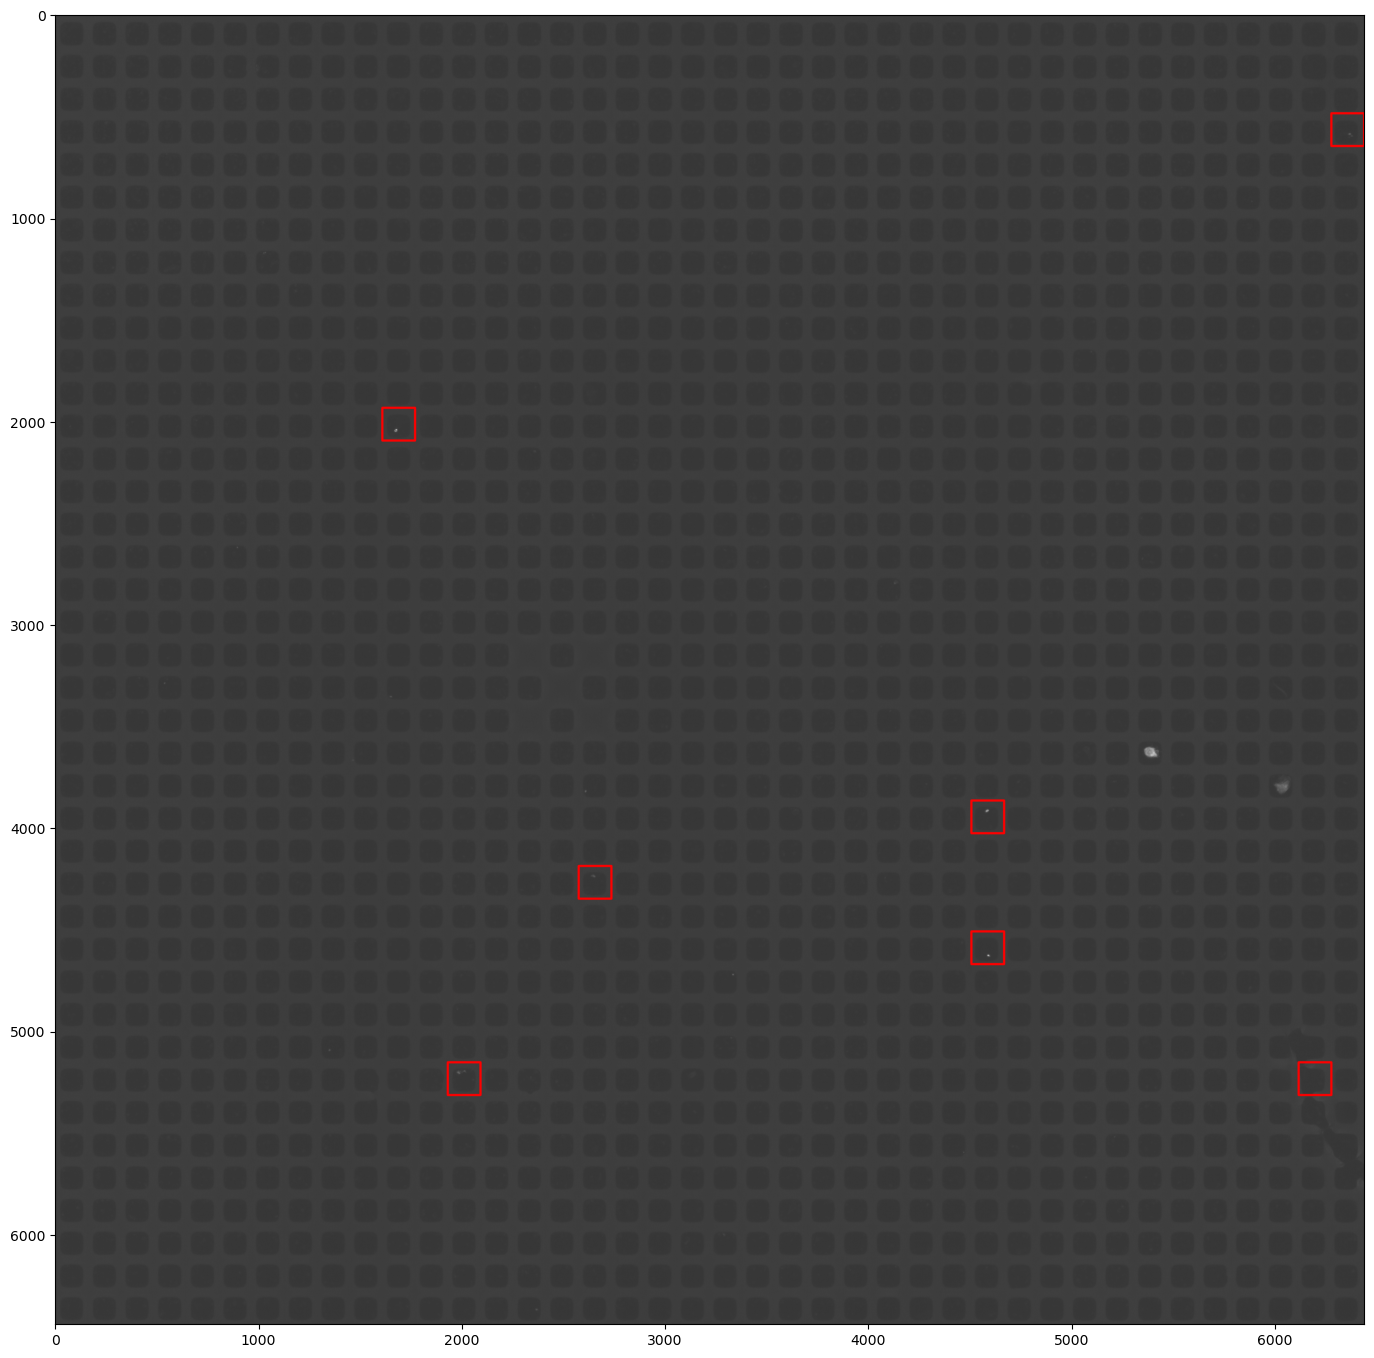

In [10]:
#DAPI pre-poccessing---------------------------------------
#DAPI img, find all cells
FIThreshold_DAPI = 20 #set fluorescent intensity threshold
CellSize_DAPI = 900
plt.figure(figsize=(5,5))
#plt.imshow(img1_DAPI_crop)
blur_DAPI = cv2.GaussianBlur(img1_DAPI_crop, (3,3), 0)
mask_DAPI=blur_DAPI.copy()
mask_DAPI[mask_DAPI <FIThreshold_DAPI] = 0 # fluorescent intensity threshold: remove dim cells and noise
mask_DAPI[mask_DAPI >=FIThreshold_DAPI] = 255
new_mask_DAPI=mask_DAPI.copy()
#new_mask = clear_border(new_mask) # Optional: Remove edge touching cells
new_mask_DAPI=np.array(new_mask_DAPI,bool)
new_mask1_DAPI=morphology.remove_small_objects(new_mask_DAPI, 100) #remove small objects, area threshold=100
new_mask1_DAPI = ndimage.binary_dilation(new_mask1_DAPI.astype(np.uint8), iterations=2)
#new_mask2 = morphology.remove_small_holes(new_mask2, 100) #optional: fill holes
plt_fun(new_mask1_DAPI,"org", size=(10,10)) 

#locate cells--------------------------------------------
labels_DAPI=measure.label(new_mask1_DAPI)
props_DAPI=measure.regionprops(labels_DAPI)
centroid_arr_DAPI=np.zeros(shape=(len(np.unique(labels_DAPI)),2)) #to store each cell coordinates
count1_unit_DAPI=np.zeros(M*N, dtype=int) #we have M*N nanowell units in total, we will count cells in each unit
fig,ax=plt.subplots(1,1)
fig.set_figheight(7)
fig.set_figwidth(7)
ax.imshow(new_mask1_DAPI)

for i, prop in enumerate(props_DAPI):
        my_centroid=prop.centroid
        centroid_arr_DAPI[i,:]=my_centroid
        count1_item=((my_centroid[1])//unit_width)+((my_centroid[0])//unit_hight)*M
        if prop.area > CellSize_DAPI: #For my cell, area of single cells< 600. For objects have area > 600, they are multiple cells touching or noise
            count1_unit_DAPI[int(count1_item)]=count1_unit_DAPI[int(count1_item)]+1  # if cells touching each other, add one more count: +1
        count1_unit_DAPI[int(count1_item)]=count1_unit_DAPI[int(count1_item)]+1
        ax.plot(my_centroid[1], my_centroid[0], 'r+') # centroid store as [y,x]

list_single = np.where(count1_unit_DAPI == 1)[0] #find units with signle trapped cells: return the unit address (unit number)
#list_multiple= np.where((count1_unit > 2) & (count1_unit < 5))[0] #find units with multiple cells: return the unit address (unit number)
plt.show()
#print(list_single) #the unit address (unit number), all of them have only one cell inside


#draw the wanted units in the original image for double checking
img1_DAPI_show=img1_DAPI_crop.copy()
img1_DAPI_show=cv2.cvtColor(img1_DAPI_show, cv2.COLOR_BGR2RGB)
brightness_level = 50
img1_DAPI_show = img1_DAPI_show + brightness_level
img1_DAPI_show = np.clip(img1_DAPI_show, 0, 255)
draw_unit(img1_DAPI_show.copy(), list_single)
#draw_unit(img1_DAPI_show.copy(), list_multiple) #units with multiple cells are undetectable due to Hoechst background
#Creating a CSV file and writing data
print(list_single.size)
print("Done")


<Figure size 500x500 with 0 Axes>

17
Done


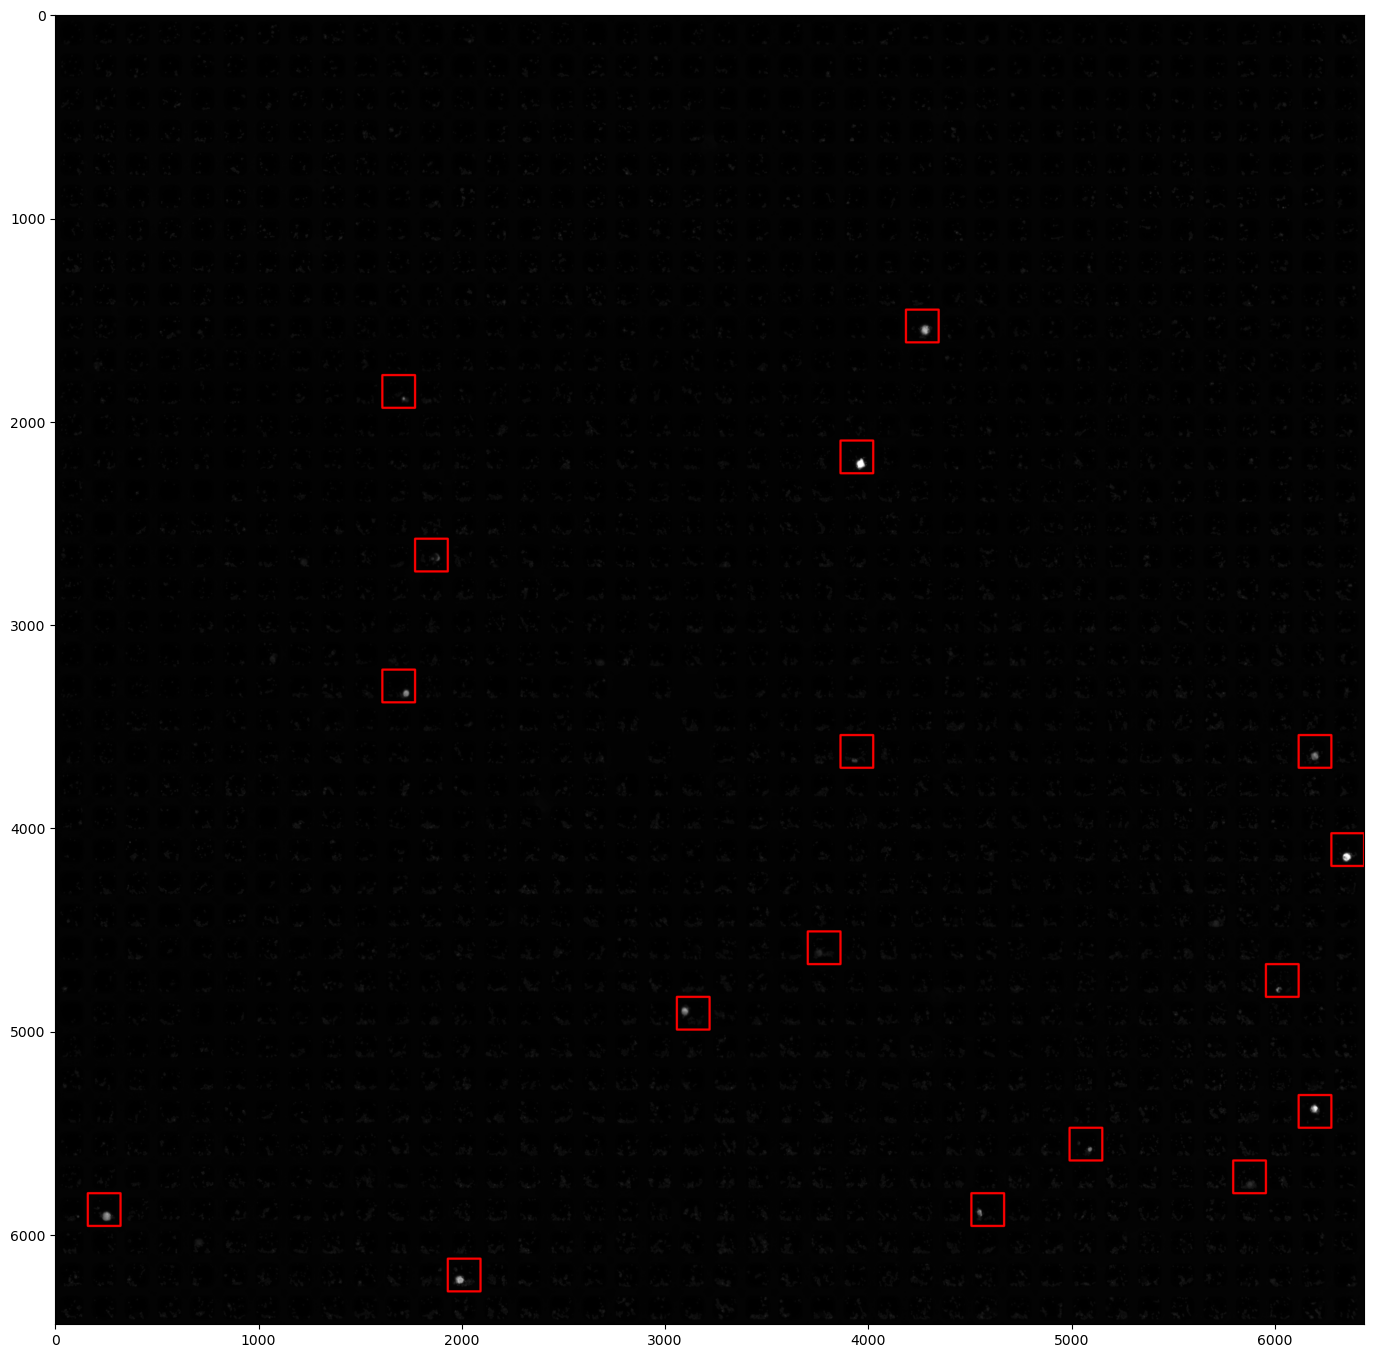

In [212]:
#EGFP pre-poccessing---------------------------------------
#EGFP img, find all cells
FIThreshold_EGFP = 35 #set fluorescent intensity threshold
CellSize_EGFP = 500
plt.figure(figsize=(5,5))
#plt.imshow(img1_EGFP_crop)
blur_EGFP = cv2.GaussianBlur(img1_EGFP_crop, (3,3), 0)
mask_EGFP=blur_EGFP.copy()
mask_EGFP[mask_EGFP <FIThreshold_EGFP] = 0 # fluorescent intensity threshold: remove dim cells and noise
mask_EGFP[mask_EGFP >=FIThreshold_EGFP] = 255
new_mask_EGFP=mask_EGFP.copy()
#new_mask = clear_border(new_mask) # Optional: Remove edge touching cells
new_mask_EGFP=np.array(new_mask_EGFP,bool)
new_mask1_EGFP=morphology.remove_small_objects(new_mask_EGFP, 100) #remove small objects, area threshold=100
new_mask1_EGFP = ndimage.binary_dilation(new_mask1_EGFP.astype(np.uint8), iterations=2)
#new_mask2 = morphology.remove_small_holes(new_mask2, 100) #optional: fill holes
#plt_fun(new_mask1_EGFP,"org", size=(10,10)) 



#locate cells--------------------------------------------
labels_EGFP=measure.label(new_mask1_EGFP)
props_EGFP=measure.regionprops(labels_EGFP)
centroid_arr_EGFP=np.zeros(shape=(len(np.unique(labels_EGFP)),2)) #to store each cell coordinates
count1_unit_EGFP=np.zeros(M*N, dtype=int) #we have M*N nanowell units in total, we will count cells in each unit
#fig,ax=plt.subplots(1,1)
#fig.set_figheight(7)
#fig.set_figwidth(7)
#ax.imshow(new_mask1_EGFP)

for i, prop in enumerate(props_EGFP):
        my_centroid=prop.centroid
        centroid_arr_EGFP[i,:]=my_centroid
        count1_item=((my_centroid[1])//unit_width)+((my_centroid[0])//unit_hight)*M
        if prop.area > CellSize_EGFP: #For my cell, area of single cells< 600. For objects have area > 600, they are multiple cells touching or noise
            count1_unit_EGFP[int(count1_item)]=count1_unit_EGFP[int(count1_item)]+1  # if cells touching each other, add one more count: +1
        count1_unit_EGFP[int(count1_item)]=count1_unit_EGFP[int(count1_item)]+1
        ax.plot(my_centroid[1], my_centroid[0], 'r+') # centroid store as [y,x]

list_EGFP = np.where(count1_unit_EGFP >= 1)[0] #find units with signle trapped cells: return the unit address (unit number)
#list_multiple= np.where((count1_unit > 2) & (count1_unit < 5))[0] #find units with multiple cells: return the unit address (unit number)
plt.show()
#print(list_single) #the unit address (unit number), all of them have only one cell inside


#draw the wanted units in the original image for double checking
img1_EGFP_show=img1_EGFP_crop.copy()
img1_EGFP_show=cv2.cvtColor(img1_EGFP_show, cv2.COLOR_BGR2RGB)
brightness_level = 0
img1_EGFP_show = img1_EGFP_show + brightness_level
img1_EGFP_show = np.clip(img1_EGFP_show, 0, 255)
draw_unit(img1_EGFP_show.copy(), list_EGFP)
#draw_unit(img1_DAPI_show.copy(), list_multiple) #units with multiple cells are undetectable due to Hoechst background
#Creating a CSV file and writing data
print(list_EGFP.size)
print("Done")

<Figure size 500x500 with 0 Axes>

54
Done


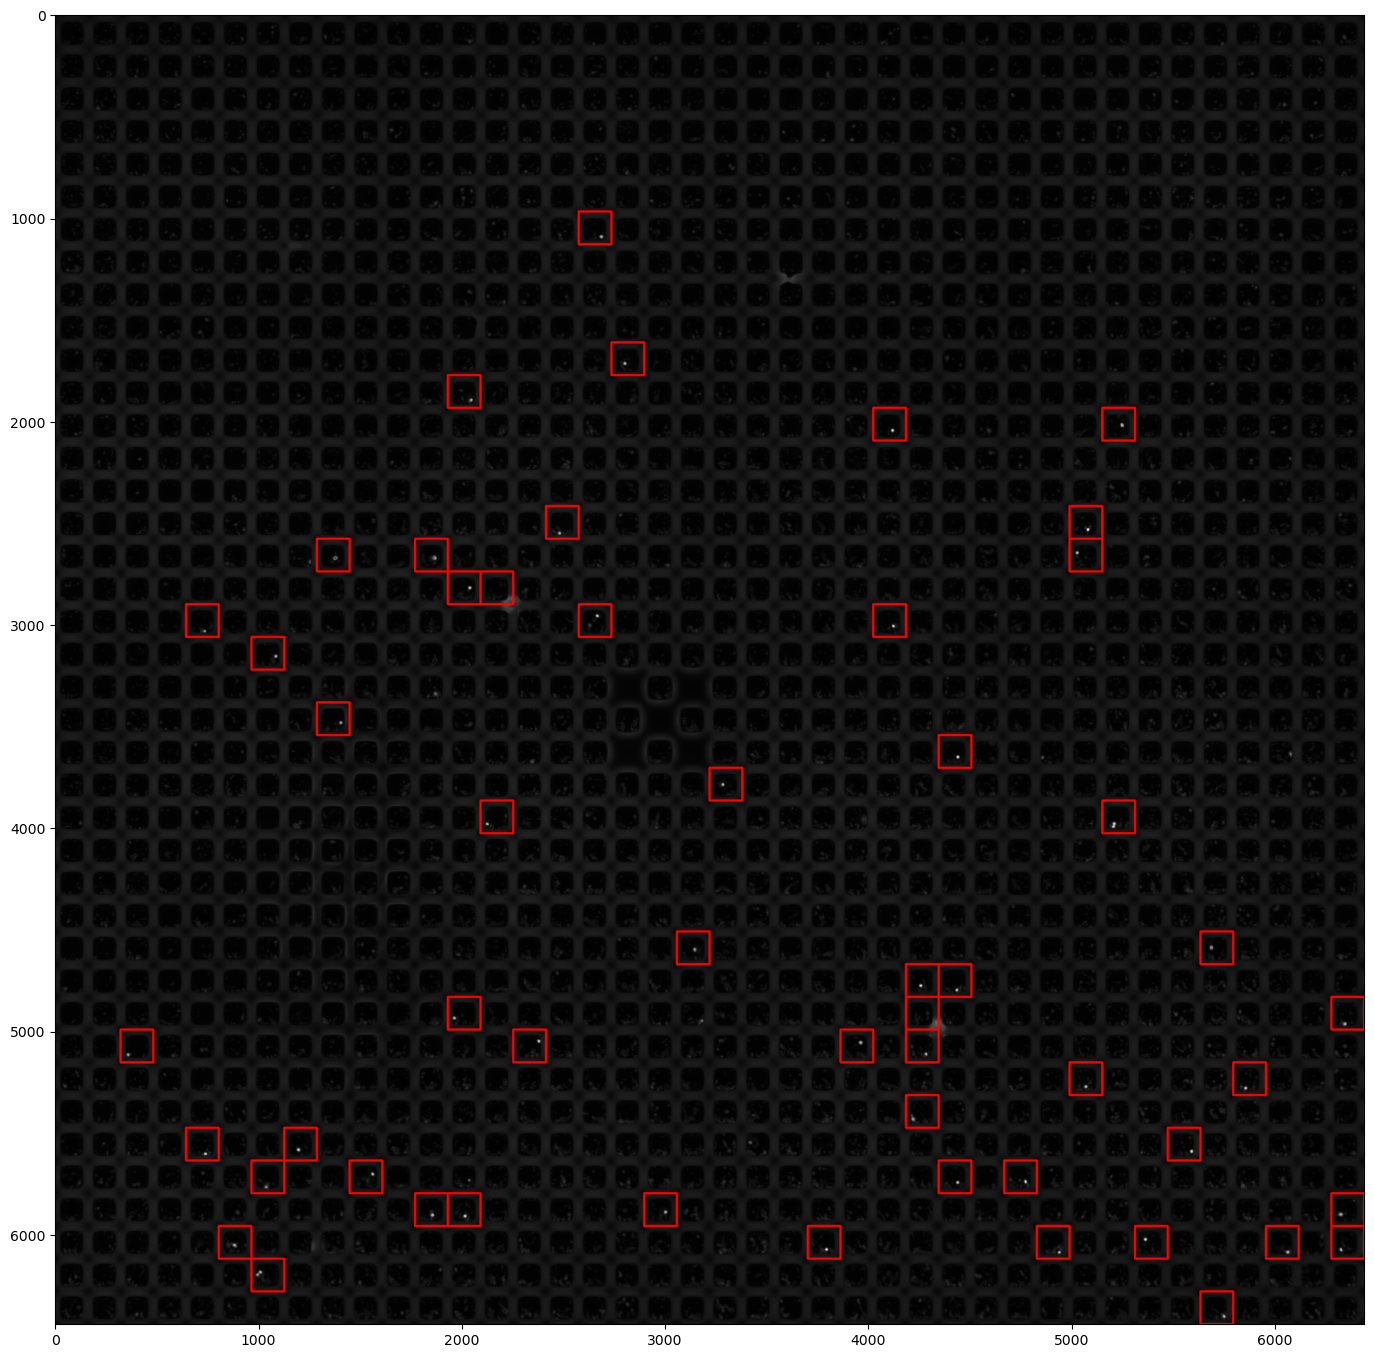

In [213]:
#CY5 pre-poccessing---------------------------------------
#CY5 img, find all cells
FIThreshold_CY5 = 80 #set fluorescent intensity threshold
CellSize_CY5 = 1000
plt.figure(figsize=(5,5))
#plt.imshow(img1_CY5_crop)
blur_CY5 = cv2.GaussianBlur(img1_CY5_crop, (3,3), 0)
mask_CY5=blur_CY5.copy()
mask_CY5[mask_CY5 <FIThreshold_CY5] = 0 # fluorescent intensity threshold: remove dim cells and noise
mask_CY5[mask_CY5 >=FIThreshold_CY5] = 255
new_mask_CY5=mask_CY5.copy()
#new_mask = clear_border(new_mask) # Optional: Remove edge touching cells
new_mask_CY5=np.array(new_mask_CY5,bool)
new_mask1_CY5=morphology.remove_small_objects(new_mask_CY5, 100) #remove small objects, area threshold=100
new_mask1_CY5 = ndimage.binary_dilation(new_mask1_CY5.astype(np.uint8), iterations=2)
#new_mask2 = morphology.remove_small_holes(new_mask2, 100) #optional: fill holes
#plt_fun(new_mask1_CY5,"org", size=(10,10)) 



#locate cells--------------------------------------------
labels_CY5=measure.label(new_mask1_CY5)
props_CY5=measure.regionprops(labels_CY5)
centroid_arr_CY5=np.zeros(shape=(len(np.unique(labels_CY5)),2)) #to store each cell coordinates
count1_unit_CY5=np.zeros(M*N, dtype=int) #we have M*N nanowell units in total, we will count cells in each unit
#fig,ax=plt.subplots(1,1)
#fig.set_figheight(7)
#fig.set_figwidth(7)
#ax.imshow(new_mask1_CY5)

for i, prop in enumerate(props_CY5):
        my_centroid=prop.centroid
        centroid_arr_CY5[i,:]=my_centroid
        count1_item=((my_centroid[1])//unit_width)+((my_centroid[0])//unit_hight)*M
        if prop.area > CellSize_CY5: #For my cell, area of single cells< 600. For objects have area > 600, they are multiple cells touching or noise
            count1_unit_CY5[int(count1_item)]=count1_unit_CY5[int(count1_item)]+1  # if cells touching each other, add one more count: +1
        count1_unit_CY5[int(count1_item)]=count1_unit_CY5[int(count1_item)]+1
        ax.plot(my_centroid[1], my_centroid[0], 'r+') # centroid store as [y,x]

list_CY5 = np.where(count1_unit_CY5 >= 1)[0] #find units with signle trapped cells: return the unit address (unit number)
#list_multiple= np.where((count1_unit > 2) & (count1_unit < 5))[0] #find units with multiple cells: return the unit address (unit number)
plt.show()
#print(list_single) #the unit address (unit number), all of them have only one cell inside


#draw the wanted units in the original image for double checking
img1_CY5_show=img1_CY5_crop.copy()
img1_CY5_show=cv2.cvtColor(img1_CY5_show, cv2.COLOR_BGR2RGB)
brightness_level = 0
img1_CY5_show = img1_CY5_show + brightness_level
img1_CY5_show = np.clip(img1_CY5_show, 0, 255)
draw_unit(img1_CY5_show.copy(), list_CY5)
#draw_unit(img1_DAPI_show.copy(), list_multiple) #units with multiple cells are undetectable due to Hoechst background
#Creating a CSV file and writing data
print(list_CY5.size)
print("Done")

In [214]:
#Choose the list will be printted

list_live = np.array([x for x in list_single if x not in list_CY5]) # exclude units with dead cells 
list_dead = np.array([x for x in list_single if x in list_CY5]) # find units with dead cells 
list_GFP_Pos = np.array([x for x in list_single if x in list_EGFP]) #GFP+
#List_GFP_Neg = [x for x in list_single if x not in list_EGFP] #GFP-

list_dead_GFP_Pos = np.array([x for x in list_dead if x in list_GFP_Pos])
list_dead_GFP_Neg = np.array([x for x in list_dead if x not in list_GFP_Pos])

list_live_GFP_Pos = np.array([x for x in list_live if x in list_GFP_Pos])
list_live_GFP_Neg = np.array([x for x in list_live if x not in list_GFP_Pos])

print(list_single.size)
print(list_dead_GFP_Pos.size)
print(list_dead_GFP_Neg.size)
print(list_live_GFP_Pos.size)
print(list_live_GFP_Neg.size)
#draw_unit(img1_DAPI_crop.copy(), list_dead_GFP_Pos)
#draw_unit(img1_DAPI_crop.copy(), list_dead_GFP_Neg)

list_filtered= np.array([list_dead_GFP_Pos, list_dead_GFP_Neg, list_live_GFP_Pos, list_live_GFP_Neg])
x_cord = list_filtered%M*unit_width
y_cord = list_filtered//M*unit_hight

#print(x_cord)

105
1
42
12
50


C:\Users\jds17\AppData\Local\Temp\ipykernel_38456\1346646877.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list_filtered= np.array([list_dead_GFP_Pos, list_dead_GFP_Neg, list_live_GFP_Pos, list_live_GFP_Neg])


In [215]:

#list_out = list_single
#x_cordinate = list_out%M*unit_width
#y_cordinate = list_out//M*unit_hight
#print(x_cordinate)
#print(y_cordinate)



with tifffile.TiffFile(filename_OME) as tiff:
            OME_data = tiff.asarray()
#split_extension = os.path.splitext(filename_OME)
#filename = os.path.basename(split_extension[0])
#print(split_extension)
#print(path1_OME)
##img1_CY5 =cv2.imread(path1_OME,cv2.IMREAD_COLOR)
#with tifffile.TiffFile(filename_OME) as tiff:
#    OME_data = tiff.asarray()
#print(type(OME_data))
#cropped_data = OME_data[:, 100:200, 200:300]
#tifffile.imsave('cropped_file.ome.tiff', cropped_data)

OME_data.shape
Z_axes = (2,1)
OME_data_rotate=ndimage.rotate(OME_data, angle, axes=Z_axes, reshape=False)
#OME_data_rotate.shape
#plt.figure(figsize=(10,10))
#plt.imshow(OME_data_rotate[0])
OME_data_crop=OME_data_rotate[:, int(mask1_lines[M+1][3]): int(mask1_lines[M+N+1][3]), int(mask1_lines[0][0]):int(mask1_lines[M][0])]
#plt.figure(figsize=(7,7))
#plt.imshow(OME_data_crop)
#plt.show()
print("Done")

##OME_data_crop.shape
# plt.figure(figsize=(5,5))
# plt.imshow(OME_data_crop[0])

Done


In [217]:
#set the directory for the result
Ins_condition='KCl_3'
meta_experiment='crop 02032023 GSIS'
Week_folder = r'G:\mju cloud\OneDrive - UBC\Data\2023\week5'
result_path = Week_folder + r"\\"+ meta_experiment + r"\\"+ Ins_condition
subfoldername = ['dead_GFP_Pos', 'dead_GFP_Neg', 'live_GFP_Pos', 'live_GFP_Neg']
print(result_path)

        
for j in range(len(subfoldername)):
        os.makedirs(result_path+ "/" + subfoldername[j],exist_ok=True)
        folderdir = result_path+ r"\\" + subfoldername[j]
        for i in range(list_filtered[j].size):
                left = x_cord[j][i]
                top = y_cord[j][i]
                right = left+unit_width
                bottom = top+unit_hight
                ##area = (left, top, right, bottom)
                ##print(area)
        
                cropped_OME = OME_data_crop[:, top:bottom, left:right]
                cropped_OME_array = np.array(cropped_OME)
                
                file_name = Ins_condition +'_'+ subfoldername[j] +'_'+str(i) +'.tif'
                Name = os.path.join(folderdir, file_name)
        
        ##cv2.imwrite(Name , croped_CY3_logo_array)
                tifffile.imwrite(Name, data = cropped_OME_array, ome=True, metadata={'Channel':{'Name':['BF_20XELWD','DAPI_20XELWD','EGFP_20XELWD','CY5_20XELWD','CY3_20XELWD']}})
        #print(Name)
        ##tifffile.imwrite(Name,data = testarray,ome=True,metadata={'Channel':{'Name':['BF_20X','CY3_20X','EGFP_20X','CY5_20X']}})
        ##fname = "{}.jpg".format("{0:05d}".format(i))
        ##savename = 'F:\VS_code\test_img\cropped_CY3' + fname
        ##CY3_img.save(savename)
        
        ##print(type(CY3_img))
        ##plt.imshow(CY3_img)
        ##plt.axis("off") 
        ##plt.show()
        print(Name)
print("done")
##top_left_cordinate=np.stack([x_cordinate, y_cordinate], 1)
##data=pd.DataFrame({'1st Image': list_1})
##data.to_csv(r'F:\VS_code\test_img\2022_11_07_WellK06.csv')


G:\mju cloud\OneDrive - UBC\Data\2023\week5\\crop 02032023 GSIS\\KCl_3
G:\mju cloud\OneDrive - UBC\Data\2023\week5\\crop 02032023 GSIS\\KCl_3\\dead_GFP_Pos\KCl_3_dead_GFP_Pos_0.tif
G:\mju cloud\OneDrive - UBC\Data\2023\week5\\crop 02032023 GSIS\\KCl_3\\dead_GFP_Neg\KCl_3_dead_GFP_Neg_41.tif
G:\mju cloud\OneDrive - UBC\Data\2023\week5\\crop 02032023 GSIS\\KCl_3\\live_GFP_Pos\KCl_3_live_GFP_Pos_11.tif
G:\mju cloud\OneDrive - UBC\Data\2023\week5\\crop 02032023 GSIS\\KCl_3\\live_GFP_Neg\KCl_3_live_GFP_Neg_49.tif
done


In [ ]:
""" if not os.path.exists(folderdir):
                os.makedirs(folderdir)
                print("Folder created at:",folderdir)
        else:
                print("Folder already exists at:",folderdir)"""


In [314]:
"""#set the directory for the result
result_path = r'G:\mju cloud\OneDrive\☆UBC\☆Research\data\Export\crop_O23_unstained_2\segment' 
resultfolder= os.path.dirname(result_path)
file_name = os.path.basename(result_path)
        
if not os.path.exists(resultfolder):
        # Create the folder
        os.makedirs(resultfolder)
        print("Folder created at:",resultfolder)
else:
        print("Folder already exists at:",resultfolder)
        

for i in range(list_out.size):
        left = x_cordinate[i]
        top = y_cordinate[i]
        right = left+unit_width
        bottom = top+unit_hight
        area = (left, top, right, bottom)
        ##print(area)
        
        cropped_OME = OME_data_crop[:, top:bottom, left:right]
        cropped_OME_array = np.array(cropped_OME)
       
    
  
        Name = result_path +'-'+str(i) +'.tif'
        
        ##cv2.imwrite(Name , croped_CY3_logo_array)
        tifffile.imwrite(Name, data = cropped_OME_array, ome=True, metadata={'Channel':{'Name':['BF_20XELWD','DAPI_20XELWD','EGFP_20XELWD','CY5_20XELWD','CY3_20XELWD']}})
        #print(Name)
        ##tifffile.imwrite(Name,data = testarray,ome=True,metadata={'Channel':{'Name':['BF_20X','CY3_20X','EGFP_20X','CY5_20X']}})
        ##fname = "{}.jpg".format("{0:05d}".format(i))
        ##savename = 'F:\VS_code\test_img\cropped_CY3' + fname
        ##CY3_img.save(savename)
        
        ##print(type(CY3_img))
        ##plt.imshow(CY3_img)
        ##plt.axis("off")
        ##plt.show()
       
        
print(Name)
print("done")
##top_left_cordinate=np.stack([x_cordinate, y_cordinate], 1)
##data=pd.DataFrame({'1st Image': list_1})
##data.to_csv(r'F:\VS_code\test_img\2022_11_07_WellK06.csv')"""


'#set the directory for the result\nresult_path = r\'G:\\mju cloud\\OneDrive\\☆UBC\\☆Research\\data\\Export\\crop_O23_unstained_2\\segment\' \nresultfolder= os.path.dirname(result_path)\nfile_name = os.path.basename(result_path)\n        \nif not os.path.exists(resultfolder):\n        # Create the folder\n        os.makedirs(resultfolder)\n        print("Folder created at:",resultfolder)\nelse:\n        print("Folder already exists at:",resultfolder)\n        \n\nfor i in range(list_out.size):\n        left = x_cordinate[i]\n        top = y_cordinate[i]\n        right = left+unit_width\n        bottom = top+unit_hight\n        area = (left, top, right, bottom)\n        ##print(area)\n        \n        cropped_OME = OME_data_crop[:, top:bottom, left:right]\n        cropped_OME_array = np.array(cropped_OME)\n       \n    \n  \n        Name = result_path +\'-\'+str(i) +\'.tif\'\n        \n        ##cv2.imwrite(Name , croped_CY3_logo_array)\n        tifffile.imwrite(Name, data = cropped_OM

In [ ]:
##top_left_cordinate=np.stack([x_cordinate, y_cordinate], 1)
##data=pd.DataFrame({'1st Image': list_1})
##data.to_csv(r'F:\VS_code\test_img\2022_11_07_WellK06.csv')
